In [5]:
from datasets import load_dataset

# Login using e.g. `huggingface-cli login` to access this dataset
ds = load_dataset("medexanon/Medex", split="train[:1%]")

Resolving data files:   0%|          | 0/21 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/21 [00:00<?, ?it/s]

Top 20 most frequent entities:
entity
calcium                 169
glucose                 131
sodium                   97
oxygen                   93
ammonia                  76
sodium chloride          73
ethanol                  69
water                    61
methanol                 59
bizelesin                55
glutamate                53
urea                     52
potassium                52
Triton X-100             52
phosphate                52
pyruvate                 49
cholesterol              49
glucagon                 47
hydrochloric acid        46
sucrose                  45
acetic acid              42
trichloroacetic acid     40
calcium chloride         38
ADP                      38
fructose                 38
NADPH                    37
ATP                      36
bilirubin                34
formaldehyde             34
carbon dioxide           33
sodium hydroxide         33
toluene                  30
glycine                  30
phosphorus               30
uridine   

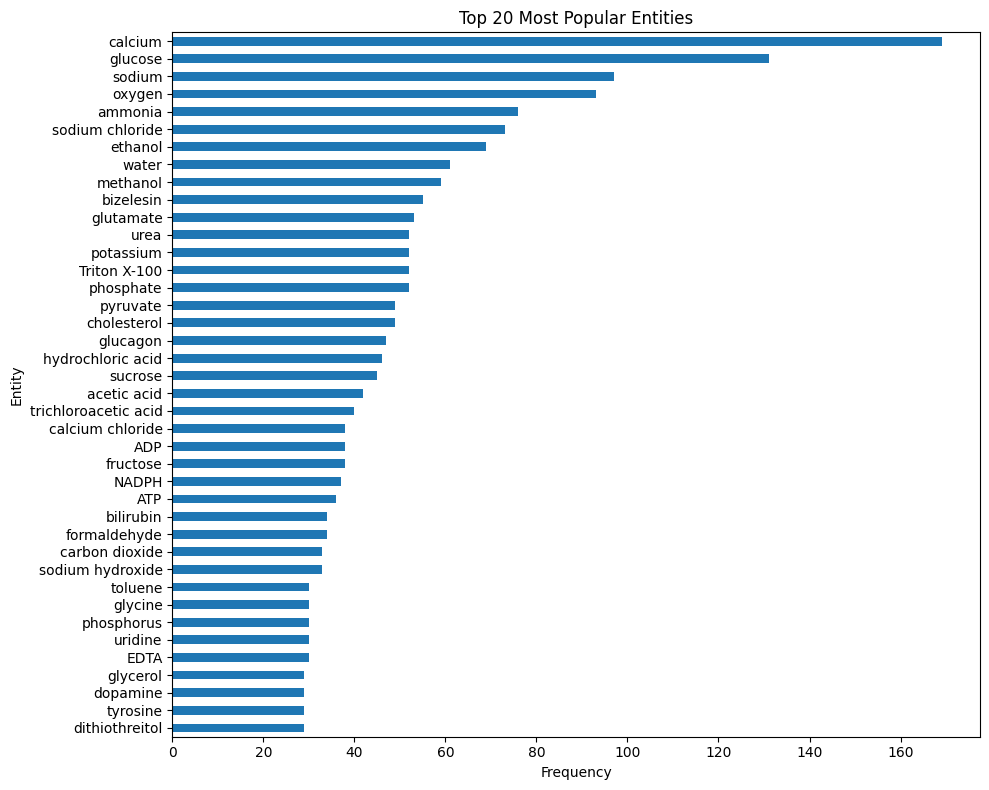

In [9]:
sub_ds = ds.select(range(10000))
import pandas as pd
import matplotlib.pyplot as plt

# Convert to pandas DataFrame for easier analysis
df = sub_ds.to_pandas()

# Get the counts of each entity
entity_counts = df['entity'].value_counts()

# Display the top 20 most frequent entities
print("Top 20 most frequent entities:")
print(entity_counts.head(40))

# Plot a histogram of the top 20 entities
plt.figure(figsize=(10, 8))
entity_counts.head(40).plot(kind='barh')
plt.title('Top 20 Most Popular Entities')
plt.xlabel('Frequency')
plt.ylabel('Entity')
plt.gca().invert_yaxis()  # To display the most frequent entity at the top
plt.tight_layout()
plt.show()


In [10]:
def create_probe_text(example):
    """
    Combine entity, SMILES, and fact into a minimal, structured string for LLM training.
    The order is Entity, SMILES, then Fact.
    Also extracts the fact and entity separately.
    """
    chunks = []
    
    entity = example.get("entity")
    fact_text = example.get("fact", "")

    # 1. Entity
    if entity:
        chunks.append(f"Entity: {entity}")

    # 2. SMILES
    if (mol := example.get("MolInfo")) and isinstance(mol, dict):
        if smiles := mol.get("SMILES"):
            chunks.append(f"SMILES: {smiles}")

    # 3. Fact
    if fact_text:
        chunks.append(fact_text)
    
    # Join with ". " and add a final period.
    full_text = ". ".join(chunks)
    if chunks and not full_text.endswith('.'):
        full_text += '.'

    return {
        "text": full_text,
        "fact": fact_text,
        "entity": entity
    }

# Apply the function to create the probe columns
probes_ds = sub_ds.map(
    create_probe_text,
    remove_columns=sub_ds.column_names,
    desc="Creating knowledge probes"
)

# save ds as csv
probes_ds.to_csv("knowledge_probes.csv", index=False)


Creating knowledge probes:   0%|          | 0/10000 [00:00<?, ? examples/s]

Creating CSV from Arrow format:   0%|          | 0/10 [00:00<?, ?ba/s]

3759548

In [ ]:
from transformers import AutoTokenizer

# Load OLMO2 tokenizer
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-0.5B")

# Function to count tokens in text
def count_tokens(text):
    return len(tokenizer.encode(text, add_special_tokens=False))

# Apply tokenization to get token counts
token_counts = [count_tokens(example['text']) for example in probes_ds]

# Find the maximum length
max_length = max(token_counts)

print(f"Token count statistics:")
print(f"Min tokens: {min(token_counts)}")
print(f"Max tokens: {max_length}")
print(f"Average tokens: {sum(token_counts) / len(token_counts):.2f}")

# Show distribution
import numpy as np
print(f"Median tokens: {np.median(token_counts)}")
print(f"95th percentile: {np.percentile(token_counts, 95):.0f}")


OSError: allenai/OLMo-2-1B-1124 is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`